# Extract annotation information from RBC-GEM
## Setup
### Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from rbc_gem_utils import (
    COBRA_CONFIGURATION,
    ROOT_PATH,
    DATABASE_PATH,
    ANNOTATION_PATH,
    MODEL_PATH,
    INTERIM_PATH,
    read_rbc_model,
    show_versions,
    get_annotation_df,
    compare_tables,
    visualize_comparison,
    split_string,
)

from rbc_gem_utils.annotation import set_sbo_default_annotations

# Display versions of last time notebook ran and worked
show_versions()


Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
beautifulsoup4                       4.12.3
bio                                   1.6.2
cobra                                0.29.0
depinfo                               2.2.0
kaleido                               0.2.1
matplotlib                            3.8.2
memote                               0.17.0
networkx                              3.2.1
notebook                              7.0.7
openpyxl                              3.1.2
pandas                                2.2.0
pre-commit                            3.6.0
pyvis                                 0.3.2
rbc-gem-utils[database,network,vis] missing
requests                             2.31.0
scipy                                1.12.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68.2.2
wheel      0.41.2

Platform Information
-------------------

### Define configuration
#### COBRA Configuration

In [2]:
COBRA_CONFIGURATION

Attribute,Description,Value
solver,Mathematical optimization solver,glpk
tolerance,"General solver tolerance (feasibility, integrality, etc.)",1e-07
lower_bound,Default reaction lower bound,-1000.0
upper_bound,Default reaction upper bound,1000.0
processes,Number of parallel processes,15
cache_directory,Path for the model cache,/Users/zhaiman/Library/Caches/cobrapy
max_cache_size,Maximum cache size in bytes,104857600
cache_expiration,Model cache expiration time in seconds (if any),None


## Load RBC-GEM model

In [3]:
model = read_rbc_model(filetype="xml")
model.reactions.sort()
model.genes.sort()
model.metabolites.sort()
model

Name,RBC_GEM
Memory address,1444fdb90
Number of metabolites,1955
Number of reactions,2777
Number of genes,649
Number of groups,74
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


## Extract annotations from model

In [4]:
compare = True
display_nunique = True
overwrite = False
reset_all = False
reset_sbo = True

In [5]:
if reset_all:
    for attr in ["reactions", "metabolites", "genes"]:
        for x in getattr(model, attr):
            x.annotation = {}

if reset_sbo:
    set_sbo_default_annotations(
        model, ["reactions", "metabolites", "genes"], verbose=False
    )

### Reactions

reactions: 2777
bigg.reaction: 799
ec-code: 371
kegg.reaction: 488
metanetx.reaction: 971
metatlas: 1396
reactome: 14
references: 882
rhea: 427
sbo: 3
spontaneous: 2
tcdb: 28
vmhreaction: 1419


,reactions,bigg.reaction,ec-code,kegg.reaction,metanetx.reaction,metatlas,reactome,references,rhea,sbo,spontaneous,tcdb,vmhreaction
0,13DAMPPOX,13DAMPPOX,1.4.3.6;1.4.3.21;1.4.3.22,NaN,MNXR94687,MAR07992,NaN,pubmed:23330127,NaN,SBO:0000176,0,NaN,13DAMPPOX
1,15KPGE1Ry,NaN,NaN,NaN,NaN,NaN,NaN,pubmed:236730;pubmed:24657656;pubmed:6597453;p...,NaN,SBO:0000176,0,NaN,NaN
2,15KPGE2Ry,NaN,NaN,NaN,NaN,NaN,NaN,pubmed:236730;pubmed:24657656;pubmed:6597453;p...,NaN,SBO:0000176,0,NaN,NaN
3,15KPGE3Ry,NaN,NaN,NaN,NaN,NaN,NaN,pubmed:236730;pubmed:24657656;pubmed:6597453;p...,NaN,SBO:0000176,0,NaN,NaN
4,15KPGF1Ry,NaN,NaN,NaN,NaN,NaN,NaN,pubmed:236730;pubmed:24657656;pubmed:6597453;p...,NaN,SBO:0000176,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2772,XYLt,XYLt,NaN,NaN,MNXR105270,MAR08867,NaN,pubmed:23506862;pubmed:4487965;pubmed:5084118,NaN,SBO:0000185,0,NaN,XYLt
2773,YYDPP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBO:0000176,0,NaN,NaN
2774,YYYTPAP,NaN,NaN,NaN,NaN,NaN,NaN,pubmed:6058286;pubmed:7002549,NaN,SBO:0000176,0,NaN,NaN
2775,ZN2Htex2,NaN,NaN,NaN,NaN,NaN,NaN,pubmed:11817695;pubmed:18936201;pubmed:33996761,NaN,SBO:0000185,0,NaN,NaN


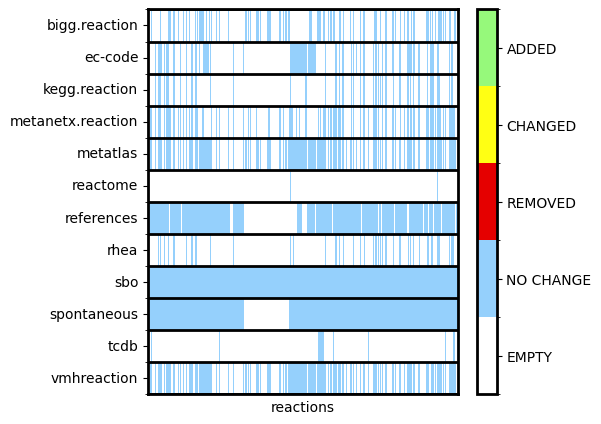

In [6]:
annotation_type = "reactions"
all_annotation_keys = set()
for annotation in getattr(model, annotation_type).list_attr("annotation"):
    all_annotation_keys.update(list(annotation.keys()))
# Get annotation df is agnostic to object type, swap ID column with the `annotation_type`
df_annotations = get_annotation_df(
    getattr(model, annotation_type), sorted(list(all_annotation_keys))
).rename({"id": annotation_type}, axis=1)

if compare:
    try:
        df_previous = pd.read_csv(
            f"{ROOT_PATH}{MODEL_PATH}/{annotation_type}.tsv",
            sep="\t",
            index_col=0,
            dtype=str,
        )
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=[annotation_type], dtype=str)

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    df_comparision = compare_tables(
        df_previous.set_index(annotation_type),
        df_annotations.set_index(annotation_type),
    )
    ax = visualize_comparison(df_comparision)

if display_nunique:
    for col in df_annotations.columns:
        df = (
            df_annotations[col]
            .apply(lambda x: split_string(x))
            .explode(col)
            .drop_duplicates()
        )
        print(f"{df.name}: {df.nunique()}")

if overwrite:
    df_annotations.to_csv(f"{ROOT_PATH}{MODEL_PATH}/{annotation_type}.tsv", sep="\t")
else:
    df_annotations.to_csv(f"{ROOT_PATH}{INTERIM_PATH}/{annotation_type}.tsv", sep="\t")
df_annotations

### Metabolites

metabolites: 1955
bigg.metabolite: 721
chebi: 681
hmdb: 413
kegg.compound: 743
lipidmaps: 204
metanetx.chemical: 1131
metatlas: 1366
pubchem.compound: 664
sbo: 1
vmhmetabolite: 1107


,metabolites,bigg.metabolite,chebi,hmdb,kegg.compound,lipidmaps,metanetx.chemical,metatlas,pubchem.compound,sbo,vmhmetabolite
0,10fthf_c,10fthf,CHEBI:15637,NaN,C00234,NaN,MNXM237,MAM00266c,122347,SBO:0000247,10fthf
1,12ppd__R_c,12ppd__R,CHEBI:16997,HMDB0001881,C00583,NaN,MNXM1118;MNXM1255;MNXM90191,MAM02771c,1030,SBO:0000247,12ppd_R
2,12ppd__S_c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBO:0000247,NaN
3,13dampp_c,13dampp,CHEBI:15725,HMDB0000002,C00986,NaN,MNXM146468;MNXM350,MAM00248c,428,SBO:0000247,13dampp
4,13dpg_c,13dpg,CHEBI:16001,NaN,C00236,NaN,MNXM261,MAM00247c,439191,SBO:0000247,13dpg
...,...,...,...,...,...,...,...,...,...,...,...
1950,zn2_c,NaN,CHEBI:29105,HMDB0015532,C00038,NaN,MNXM149,MAM03157c,32051,SBO:0000247,zn2
1951,zn2_e,NaN,CHEBI:29105,HMDB0015532,C00038,NaN,MNXM149,MAM03157e,32051,SBO:0000247,zn2
1952,ztp_c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBO:0000247,NaN
1953,zymst_c,zymst,CHEBI:18252,NaN,C05437,LMST01010066,MNXM574,MAM03158c,92746,SBO:0000247,zymst


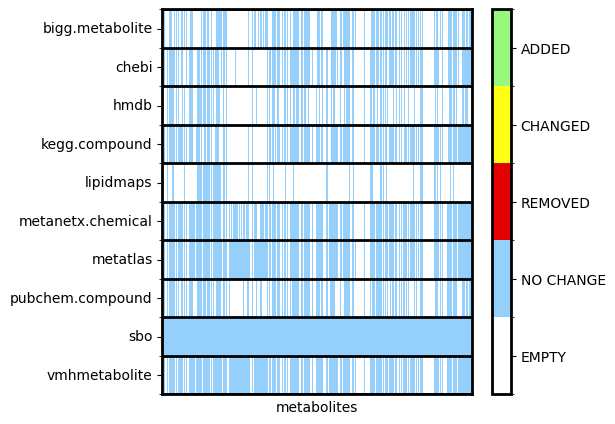

In [7]:
annotation_type = "metabolites"
all_annotation_keys = set()
for annotation in getattr(model, annotation_type).list_attr("annotation"):
    all_annotation_keys.update(list(annotation.keys()))
# Get annotation df is agnostic to object type, swap ID column with the `annotation_type`
df_annotations = get_annotation_df(
    getattr(model, annotation_type), sorted(list(all_annotation_keys))
).rename({"id": annotation_type}, axis=1)

if compare:
    try:
        df_previous = pd.read_csv(
            f"{ROOT_PATH}{MODEL_PATH}/{annotation_type}.tsv",
            sep="\t",
            index_col=0,
            dtype=str,
        )
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=[annotation_type], dtype=str)

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    df_comparision = compare_tables(
        df_previous.set_index(annotation_type),
        df_annotations.set_index(annotation_type),
    )
    ax = visualize_comparison(df_comparision)

if display_nunique:
    for col in df_annotations.columns:
        df = (
            df_annotations[col]
            .apply(lambda x: split_string(x))
            .explode(col)
            .drop_duplicates()
        )
        print(f"{df.name}: {df.nunique()}")

if overwrite:
    df_annotations.to_csv(f"{ROOT_PATH}{MODEL_PATH}/{annotation_type}.tsv", sep="\t")
else:
    df_annotations.to_csv(f"{ROOT_PATH}{INTERIM_PATH}/{annotation_type}.tsv", sep="\t")
df_annotations

### Genes

genes: 649
bgee.gene: 648
biocyc: 243
biogrid: 651
bmrb: 67
brenda: 369
cazy: 16
ccds: 1128
cdd: 522
chembl.target: 436
complexportal: 149
dbsnp: 4108
dip: 182
disprot: 33
drugbank: 2065
drugcentral: 640
ec-code: 481
eggnog: 494
ena.embl: 6901
ensembl: 464
genecards: 650
genetree: 592
genewiki: 486
go: 5213
hamap: 86
hgnc: 650
hgnc.symbol: 650
hogenom: 474
hpa: 648
ideal: 20
interpro: 1644
kegg.genes: 630
merops: 33
mgi: 681
mim: 1124
ncbigene: 653
nextprot: 649
oma.grp: 618
orphanet: 455
orthodb: 464
panther.family: 1100
pdb: 9365
peroxibase: 11
pfam: 611
pharmgkb.gene: 645
pirsf: 132
prints: 179
prosite: 355
proteomicsdb.protein: 1391
reactome: 892
references: 592
refseq: 1953
sasbdb: 29
sbo: 1
smart: 147
smpdb: 605
smr: 633
supfam: 282
taxonomy: 1
tcdb: 127
treefam: 496
uniparc: 649
uniprot: 649
uniprot.chain: 682


,genes,bgee.gene,biocyc,biogrid,bmrb,brenda,cazy,ccds,cdd,chembl.target,...,smart,smpdb,smr,supfam,taxonomy,tcdb,treefam,uniparc,uniprot,uniprot.chain
0,A4GALT,ENSG00000128274,MetaCyc:HS05171-MONOMER,119825,NaN,2.4.1.228,GT32,CCDS14041.1,NaN,NaN,...,NaN,NaN,NaN,SSF53448,9606,NaN,TF324053,UPI000003FF92,Q9NPC4,PRO_0000080578
1,AARS1,ENSG00000090861,NaN,106534,NaN,NaN,NaN,CCDS32474.1,cd00673,CHEMBL3574,...,SM00863,SMP0000055;SMP0000313;SMP0000350;SMP0000352,P49588,SSF55681;SSF101353;SSF55186;SSF50447,9606,NaN,TF300737,UPI0000169F0B,P49588,PRO_0000075281
2,AASDHPPT,ENSG00000149313,MetaCyc:HS14278-MONOMER,121927,NaN,2.7.8.7,NaN,CCDS31664.1,NaN,CHEMBL3137295,...,NaN,NaN,Q9NRN7,SSF56214,9606,NaN,TF313753,UPI0000034CAD,Q9NRN7,PRO_0000175736
3,ABCA1,ENSG00000165029,NaN,106537,NaN,NaN,NaN,CCDS6762.1,cd03263,CHEMBL2362986,...,SM00382,NaN,O95477,SSF52540,9606,3.A.1.211.14,TF105191,UPI000013E441,O95477,PRO_0000093288
4,ABCA7,ENSG00000064687,NaN,115629,NaN,NaN,NaN,CCDS12055.1,cd03263,NaN,...,SM00382,NaN,Q8IZY2,SSF52540,9606,3.A.1.211.10,TF105191,UPI000013D3A4,Q8IZY2,PRO_0000250674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,YARS1,ENSG00000134684,NaN,114134,NaN,6.1.1.1,NaN,CCDS368.1,cd02799;cd00805,CHEMBL3179,...,NaN,SMP0000008;SMP0000206;SMP0000369;SMP0000370,P54577,SSF50249;SSF52374,9606,NaN,TF300898,UPI0000136762,P54577,PRO_0000423285;PRO_0000055673
645,ZDHHC2,ENSG00000104219,NaN,119374,NaN,2.3.1.225,NaN,CCDS47810.1,NaN,CHEMBL5169204,...,NaN,NaN,Q9UIJ5,NaN,9606,NaN,TF316044,UPI000004A02F,Q9UIJ5,PRO_0000212859
646,ZDHHC20,ENSG00000180776,NaN,128991,NaN,NaN,NaN,CCDS45017.1;CCDS81758.1,NaN,CHEMBL5169156,...,NaN,NaN,Q5W0Z9,NaN,9606,8.A.114.1.6,TF316044,UPI000045881B,Q5W0Z9,PRO_0000212906
647,ZDHHC3,ENSG00000163812,NaN,119455,NaN,2.3.1.225,NaN,CCDS2724.1;CCDS46811.1,NaN,NaN,...,NaN,NaN,Q9NYG2,NaN,9606,NaN,TF319798,UPI000002B749,Q9NYG2,PRO_0000422064


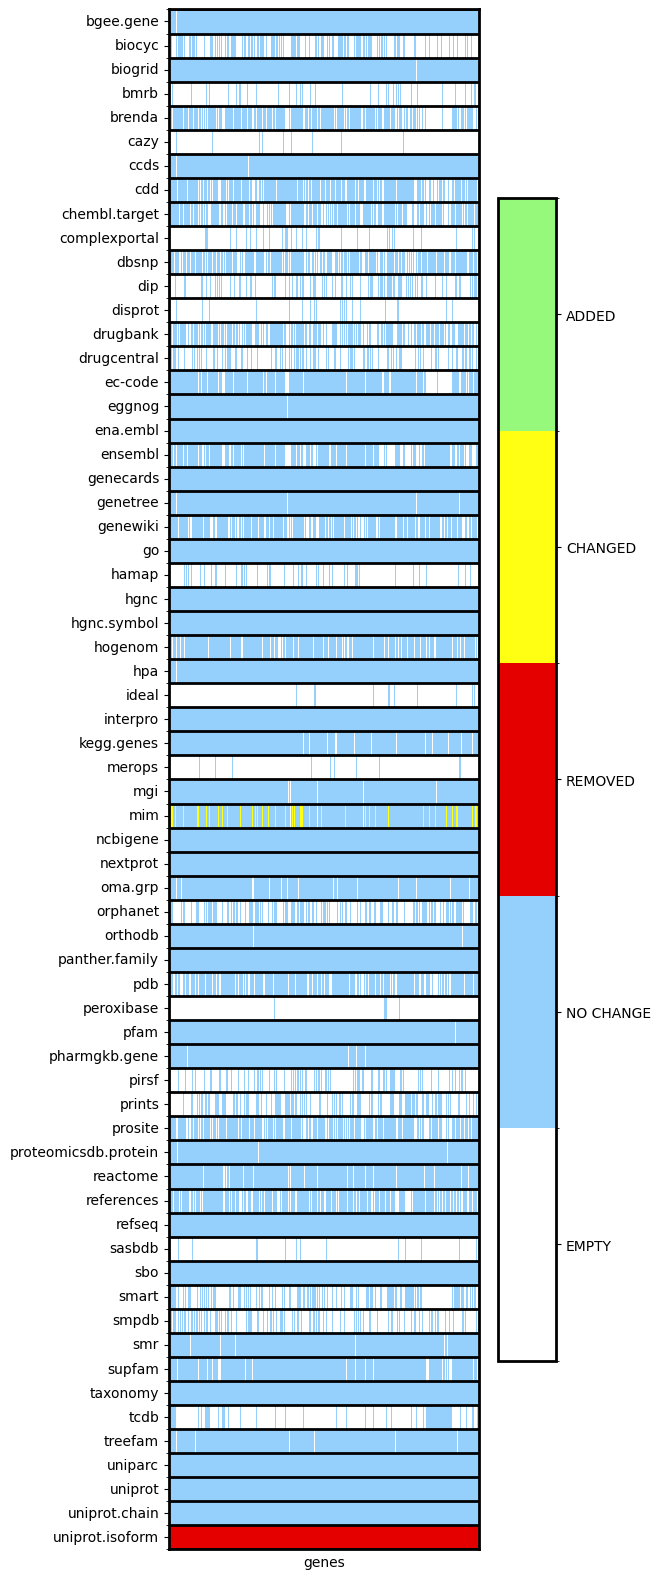

In [8]:
annotation_type = "genes"
all_annotation_keys = set()
for annotation in getattr(model, annotation_type).list_attr("annotation"):
    all_annotation_keys.update(list(annotation.keys()))
# Get annotation df is agnostic to object type, swap ID column with the `annotation_type`
df_annotations = get_annotation_df(
    getattr(model, annotation_type), sorted(list(all_annotation_keys))
).rename({"id": annotation_type}, axis=1)

if compare:
    try:
        df_previous = pd.read_csv(
            f"{ROOT_PATH}{MODEL_PATH}/{annotation_type}.tsv",
            sep="\t",
            index_col=0,
            dtype=str,
        )
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=[annotation_type], dtype=str)

    fig, ax = plt.subplots(1, 1, figsize=(5, 20))
    df_comparision = compare_tables(
        df_previous.set_index(annotation_type),
        df_annotations.set_index(annotation_type),
    )
    ax = visualize_comparison(df_comparision)

if display_nunique:
    for col in df_annotations.columns:
        df = (
            df_annotations[col]
            .apply(lambda x: split_string(x))
            .explode(col)
            .drop_duplicates()
        )
        print(f"{df.name}: {df.nunique()}")

if overwrite:
    df_annotations.to_csv(f"{ROOT_PATH}{MODEL_PATH}/{annotation_type}.tsv", sep="\t")
else:
    df_annotations.to_csv(f"{ROOT_PATH}{INTERIM_PATH}/{annotation_type}.tsv", sep="\t")
df_annotations